In [12]:
from __future__ import print_function
#%matplotlib inline

#%matplotlib inline
ngpu = 1
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import utils, datasets, transforms
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
from torch.utils.data import DataLoader
torch.__version__

Random Seed:  999


'1.12.1'

In [4]:
# Root directory for dataset
#dataroot = "data/img_align_celeba"
dataroot = "data/mnist"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 512

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [5]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')


dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

Total Size of Dataset: 70000


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

torch.Size([512, 1, 64, 64])


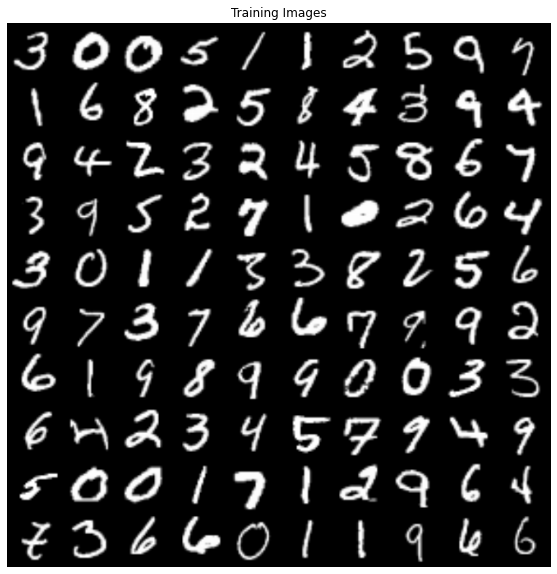

In [8]:
inputs = next(iter(dataloader))[0]
print(inputs.shape)
plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100]*0.5+0.5, nrow=10)
plt.imshow(inputs.permute(1, 2, 0))
plt.savefig("number_orig.png")

In [15]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)
# Print the model

noise = torch.randn(b_size, nz, 1, 1, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netG(noise)
print(fake.shape)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
noise = torch.randn(359, 1, 64, 64, device=device)
print(noise.shape)
        # Generate fake image batch with G
fake = netD(noise)
print(fake.shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
torch.Size([359, 1, 64, 64])
t

In [17]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [18]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
     #   print('netD output')
     #   print(output)
        #print(output)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
       # print('netD of the fake output')
      #  print(output)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
       # print('netD of the real output')
        #print(output)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/137]	Loss_D: 1.5851	Loss_G: 4.2920	D(x): 0.5425	D(G(z)): 0.5268 / 0.0241
[0/50][50/137]	Loss_D: 1.4318	Loss_G: 34.8385	D(x): 0.5514	D(G(z)): 0.0000 / 0.0000
[0/50][100/137]	Loss_D: 4.8323	Loss_G: 23.7786	D(x): 0.9805	D(G(z)): 0.7953 / 0.0000
[1/50][0/137]	Loss_D: 0.1298	Loss_G: 5.9419	D(x): 0.9605	D(G(z)): 0.0788 / 0.0034
[1/50][50/137]	Loss_D: 0.1445	Loss_G: 3.6809	D(x): 0.9330	D(G(z)): 0.0621 / 0.0314
[1/50][100/137]	Loss_D: 0.1111	Loss_G: 4.4315	D(x): 0.9580	D(G(z)): 0.0606 / 0.0176
[2/50][0/137]	Loss_D: 0.1558	Loss_G: 3.9326	D(x): 0.9287	D(G(z)): 0.0654 / 0.0316
[2/50][50/137]	Loss_D: 0.2003	Loss_G: 3.5516	D(x): 0.9114	D(G(z)): 0.0895 / 0.0415
[2/50][100/137]	Loss_D: 0.4680	Loss_G: 3.4526	D(x): 0.9672	D(G(z)): 0.3108 / 0.0517
[3/50][0/137]	Loss_D: 0.1744	Loss_G: 3.0523	D(x): 0.9202	D(G(z)): 0.0789 / 0.0656
[3/50][50/137]	Loss_D: 0.3908	Loss_G: 3.0107	D(x): 0.8745	D(G(z)): 0.2071 / 0.0666
[3/50][100/137]	Loss_D: 0.4786	Loss_G: 1.8219	D(x): 0.6993	D

[32/50][100/137]	Loss_D: 0.0781	Loss_G: 3.7071	D(x): 0.9536	D(G(z)): 0.0286 / 0.0349
[33/50][0/137]	Loss_D: 0.0628	Loss_G: 3.9981	D(x): 0.9684	D(G(z)): 0.0293 / 0.0263
[33/50][50/137]	Loss_D: 0.5804	Loss_G: 1.6897	D(x): 0.7066	D(G(z)): 0.1757 / 0.2191
[33/50][100/137]	Loss_D: 0.5775	Loss_G: 1.8035	D(x): 0.6564	D(G(z)): 0.0989 / 0.2114
[34/50][0/137]	Loss_D: 0.2646	Loss_G: 2.7577	D(x): 0.9085	D(G(z)): 0.1406 / 0.0845
[34/50][50/137]	Loss_D: 0.5814	Loss_G: 2.0698	D(x): 0.7663	D(G(z)): 0.2431 / 0.1565
[34/50][100/137]	Loss_D: 0.3275	Loss_G: 2.5177	D(x): 0.8487	D(G(z)): 0.1355 / 0.1055
[35/50][0/137]	Loss_D: 0.4134	Loss_G: 2.3277	D(x): 0.8136	D(G(z)): 0.1633 / 0.1272
[35/50][50/137]	Loss_D: 0.1110	Loss_G: 4.1195	D(x): 0.9662	D(G(z)): 0.0714 / 0.0221
[35/50][100/137]	Loss_D: 0.0629	Loss_G: 4.0400	D(x): 0.9724	D(G(z)): 0.0329 / 0.0260
[36/50][0/137]	Loss_D: 1.1014	Loss_G: 2.1934	D(x): 0.7914	D(G(z)): 0.5409 / 0.1312
[36/50][50/137]	Loss_D: 0.1847	Loss_G: 3.9778	D(x): 0.9449	D(G(z)): 0.1140 /

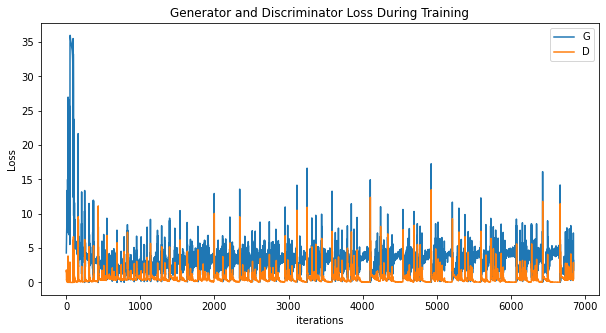

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
from PIL import Image
with torch.no_grad():
    inputs = netG(fixed_noise).detach().cpu()
       # print('fake sahpe is ',inputs.shape)
    #print('fake sahpe is ',inputs.shape)
plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100]*0.5+0.5, nrow=10)
plt.imshow(inputs.permute(1, 2, 0))
plt.savefig('number_syn.png')

NameError: name 'netG' is not defined